Project goal:
Are there natural groups of physiological responses across individuals/phases?
Do those clusters align with experimental phases (e.g. stress vs. rest?)
Can you interpret clutsers using emotion questionnaire scores?

## Imports

In [85]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, show

## Loading data

In [51]:
case2_data = pd.read_csv("data-2/HR_data.csv")

#case2_data.head()

print(case2_data.columns.tolist())

['Unnamed: 0', 'HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT', 'Round', 'Phase', 'Individual', 'Puzzler', 'Frustrated', 'Cohort', 'upset', 'hostile', 'aler

1. Data Preprocessing
- Standardize all features (StandardScaler)
- Reduce noise/correlated features with PCA (keep 95% variance)

In [52]:
# separating features from metadata/labels/categoricals
features = case2_data.iloc[:, 1:52]

# checking for missing values
nan_counts = pd.DataFrame(np.sum(pd.isna(features)), columns=["NaN count"])
nan_counts[nan_counts["NaN count"] > 0]

# filling missing values with the mean of the column
features_clean = features.fillna(features.mean())

# standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_clean)

In [48]:
# dimensionality reduction (optional?)
pca = PCA(n_components=0.95) # retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

2. Clustering Analysis 
Apply and compare:
- K-Means: Elbow method, gap statistic, or silhouette score to choose K
- Hierarchical clustering: Try different linkage (ward, average) and distance metrics
- Gaussian Mixture Models (GMM): USe AIC/BIC to choose number of components
- SOM  (Self-Organizing Maps) - to explore data topology visually

## a. K-Means

In [78]:
# ---- KMeans on X_pca ----
best_score_pca = -1
best_k_pca = None
best_labels_pca = None
sil_scores_pca = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    sil_scores_pca.append(score)

    if score > best_score_pca:
        best_score_pca = score
        best_k_pca = k
        best_labels_pca = labels

print(f"[X_pca] Best K: {best_k_pca}, Silhouette Score: {best_score_pca:.3f}")
case2_data['kmeans_sil_cluster_pca'] = best_labels_pca

# ---- KMeans on X_scaled ----
best_score_scaled = -1
best_k_scaled = None
best_labels_scaled = None
sil_scores_scaled = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores_scaled.append(score)

    if score > best_score_scaled:
        best_score_scaled = score
        best_k_scaled = k
        best_labels_scaled = labels

print(f"[X_scaled] Best K: {best_k_scaled}, Silhouette Score: {best_score_scaled:.3f}")
case2_data['kmeans_sil_cluster_scaled'] = best_labels_scaled


[X_pca] Best K: 2, Silhouette Score: 0.383
[X_scaled] Best K: 2, Silhouette Score: 0.377


In [60]:
def compute_gap_statistic(X, max_k=10, B=10):
    from sklearn.metrics import pairwise_distances
    from scipy.spatial.distance import cdist
    from numpy.random import uniform

    gaps = []
    for k in range(1, max_k+1):
        km = KMeans(n_clusters=k).fit(X)
        Wk = np.sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1))
        
        Wk_refs = []
        for _ in range(B):
            X_ref = uniform(X.min(axis=0), X.max(axis=0), X.shape)
            km_ref = KMeans(n_clusters=k).fit(X_ref)
            Wk_refs.append(np.sum(np.min(cdist(X_ref, km_ref.cluster_centers_, 'euclidean'), axis=1)))
        
        gap = np.log(np.mean(Wk_refs)) - np.log(Wk)
        gaps.append(gap)
    
    return gaps

#gaps = compute_gap_statistic(X_pca)
# error when running this? limit threads

# same problem with this
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances
# from sklearn.datasets import make_blobs

# def calculate_wk(data, labels):
#     clusters = np.unique(labels)
#     wk = 0
#     for cluster in clusters:
#         cluster_points = data[labels == cluster]
#         if len(cluster_points) > 1:
#             wk += np.sum(pairwise_distances(cluster_points, metric='euclidean')**2) / (2 * len(cluster_points))
#     return wk

# def gap_statistic(data, max_k=10, n_refs=10):
#     gaps = []
#     for k in range(1, max_k + 1):
#         kmeans = KMeans(n_clusters=k)
#         kmeans.fit(data)
#         wk = calculate_wk(data, kmeans.labels_)

#         # Generate reference datasets
#         ref_wks = []
#         for _ in range(n_refs):
#             ref_data = np.random.uniform(data.min(axis=0), data.max(axis=0), size=data.shape)
#             ref_kmeans = KMeans(n_clusters=k)
#             ref_kmeans.fit(ref_data)
#             ref_wks.append(calculate_wk(ref_data, ref_kmeans.labels_))

#         gap = np.mean(np.log(ref_wks)) - np.log(wk)
#         gaps.append(gap)

#     return np.argmax(gaps) + 1, gaps

# Example usage
# data, _ = make_blobs(n_samples=500, centers=5, random_state=42)
# optimal_k, gaps = gap_statistic(data)
# print(f"Optimal number of clusters: {optimal_k}")



## b. Hierarchical Clustering

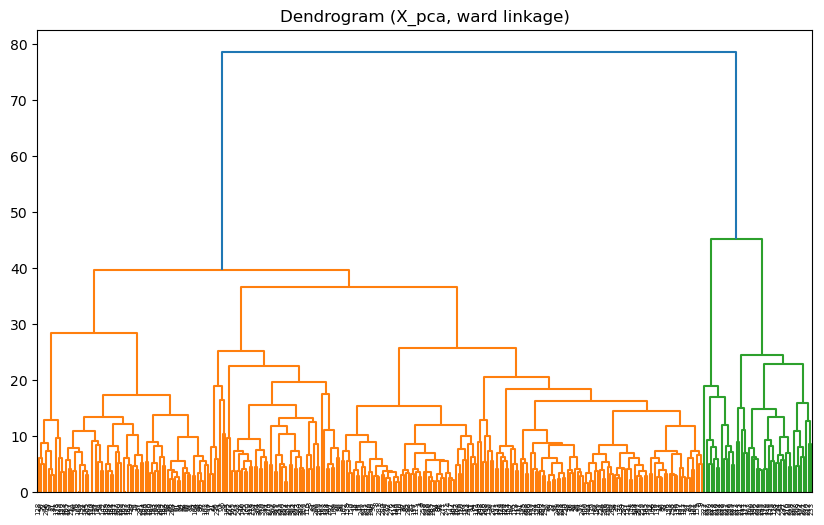

[X_pca] Best K (hierarchical): 2, Silhouette Score: 0.370


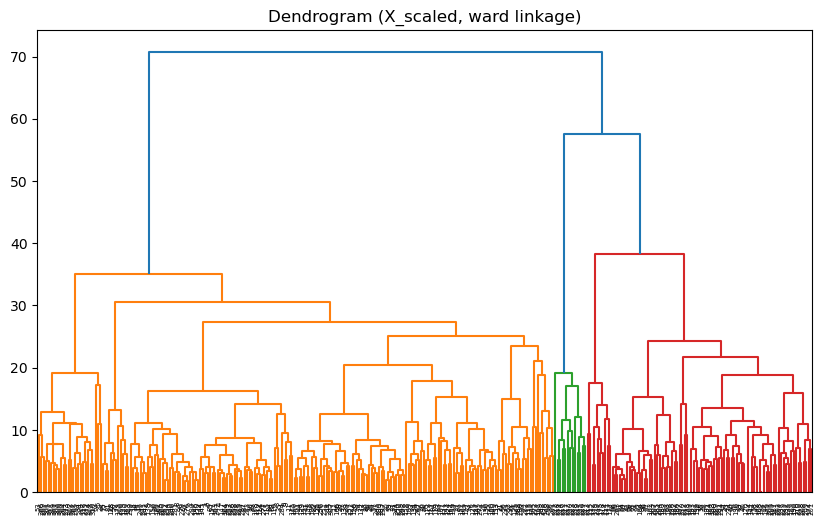

[X_scaled] Best K (hierarchical): 2, Silhouette Score: 0.182


In [79]:
# ward linkage is used here for example, we could try different types of linkage

# ---- Hierarchical on X_pca ----
Z_pca = linkage(X_pca, method='ward')
plt.figure(figsize=(10, 6))
plt.title("Dendrogram (X_pca, ward linkage)")
dendrogram(Z_pca)
plt.show()

best_score_pca = -1
best_k_pca = None
best_labels_pca = None
sil_scores_hier_pca = []

for k in range(2, 10):
    labels = fcluster(Z_pca, t=k, criterion='maxclust')
    score = silhouette_score(X_pca, labels)
    sil_scores_hier_pca.append(score)

    if score > best_score_pca:
        best_score_pca = score
        best_k_pca = k
        best_labels_pca = labels

print(f"[X_pca] Best K (hierarchical): {best_k_pca}, Silhouette Score: {best_score_pca:.3f}")
case2_data['hclust_sil_cluster_pca'] = best_labels_pca

# ---- Hierarchical on X_scaled ----
Z_scaled = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
plt.title("Dendrogram (X_scaled, ward linkage)")
dendrogram(Z_scaled)
plt.show()

best_score_scaled = -1
best_k_scaled = None
best_labels_scaled = None
sil_scores_hier_scaled = []

for k in range(2, 10):
    labels = fcluster(Z_scaled, t=k, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    sil_scores_hier_scaled.append(score)

    if score > best_score_scaled:
        best_score_scaled = score
        best_k_scaled = k
        best_labels_scaled = labels

print(f"[X_scaled] Best K (hierarchical): {best_k_scaled}, Silhouette Score: {best_score_scaled:.3f}")
case2_data['hclust_sil_cluster_scaled'] = best_labels_scaled

## c. Gaussian Mixture Model (GMM)

In [91]:
bics = []
sil_scores_gmm = []
best_score = -1
best_k = None
best_labels = None

for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_pca)
    labels = gmm.predict(X_pca)

    bic = gmm.bic(X_pca)
    bics.append(bic)

    sil = silhouette_score(X_pca, labels)
    sil_scores_gmm.append(sil)

    if sil > best_score:
        best_score = sil
        best_k = k
        best_labels = labels

print(f"[X_pca] Best K (GMM): {best_k}, Silhouette Score: {best_score:.3f}")

case2_data['gmm_sil_cluster_pca'] = best_labels

bics_scaled = []
sil_scores_gmm_scaled = []
best_score_scaled = -1
best_k_scaled = None
best_labels_scaled = None

for k in range(2, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    bic = gmm.bic(X_scaled)
    bics_scaled.append(bic)

    sil = silhouette_score(X_scaled, labels)
    sil_scores_gmm_scaled.append(sil)

    if sil > best_score_scaled:
        best_score_scaled = sil
        best_k_scaled = k
        best_labels_scaled = labels

print(f"[X_scaled] Best K (GMM): {best_k_scaled}, Silhouette Score: {best_score_scaled:.3f}")
case2_data['gmm_sil_cluster_scaled'] = best_labels_scaled

[X_pca] Best K (GMM): 2, Silhouette Score: 0.319
[X_scaled] Best K (GMM): 2, Silhouette Score: 0.377


## SOM

/Users/idasofieadrian/opt/miniconda3/lib/python3.8/site-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


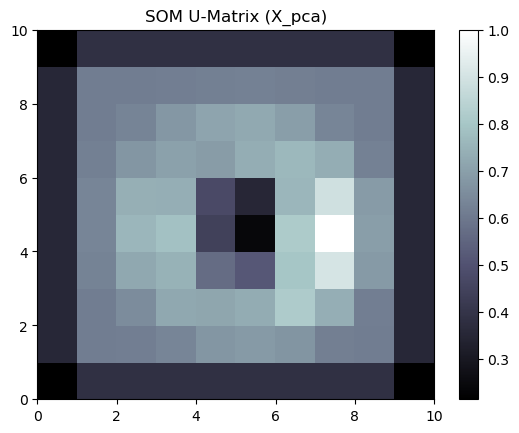

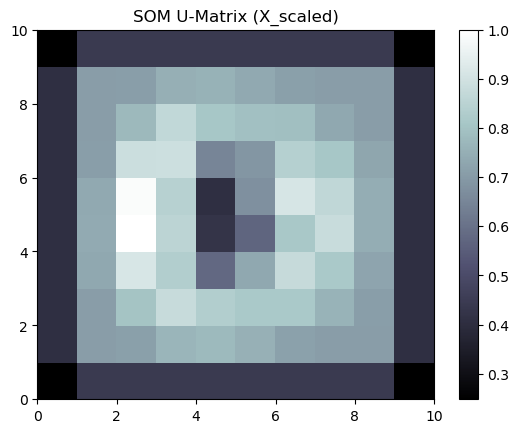

In [86]:
# Initialize SOM
som_pca = MiniSom(10, 10, X_pca.shape[1], sigma=0.5, learning_rate=0.5)
som_pca.pca_weights_init(X_pca)
som_pca.train_random(X_pca, 1000)

# U-Matrix
bone()
pcolor(som_pca.distance_map().T)
colorbar()
plt.title("SOM U-Matrix (X_pca)")
show()

# Assign BMU positions as cluster proxy
som_labels_pca = [som_pca.winner(x) for x in X_pca]
# Convert (i,j) coords to 1D labels
som_cluster_ids_pca = [i * 10 + j for i, j in som_labels_pca]
case2_data['som_cluster_pca'] = som_cluster_ids_pca

som_scaled = MiniSom(10, 10, X_scaled.shape[1], sigma=0.5, learning_rate=0.5)
som_scaled.pca_weights_init(X_scaled)
som_scaled.train_random(X_scaled, 1000)

bone()
pcolor(som_scaled.distance_map().T)
colorbar()
plt.title("SOM U-Matrix (X_scaled)")
show()

som_labels_scaled = [som_scaled.winner(x) for x in X_scaled]
som_cluster_ids_scaled = [i * 10 + j for i, j in som_labels_scaled]
case2_data['som_cluster_scaled'] = som_cluster_ids_scaled

3. Cluster Interpretation
- Visualize clusters using: PCA (2D scatterplot with cluster labels)
- Compare clusters with: Phase labels (pre, puzzle, post) & Self-rated emotion scores (fx average frustration per cluster)
- Heatmaps of mean feature values per cluster

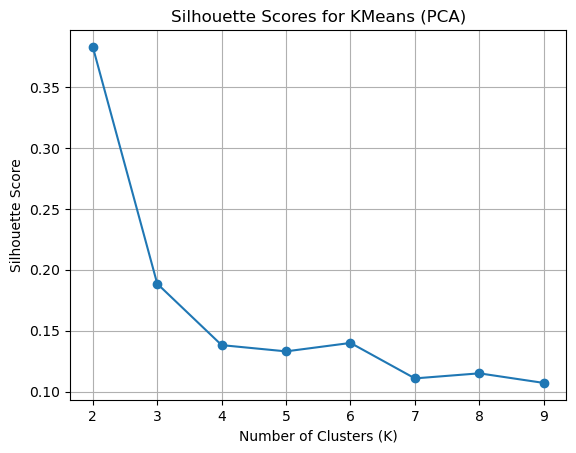

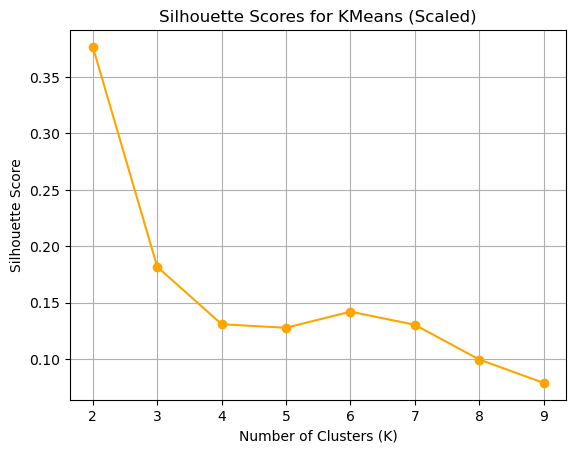

In [87]:
# sil plot for KMeans
# PCA input
plt.plot(range(2, 10), sil_scores_pca, marker='o', label='PCA')
plt.title("Silhouette Scores for KMeans (PCA)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Scaled input
plt.plot(range(2, 10), sil_scores_scaled, marker='o', color='orange', label='Scaled')
plt.title("Silhouette Scores for KMeans (Scaled)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()



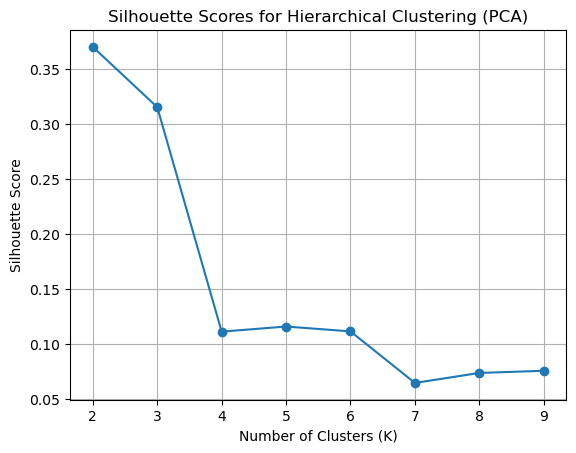

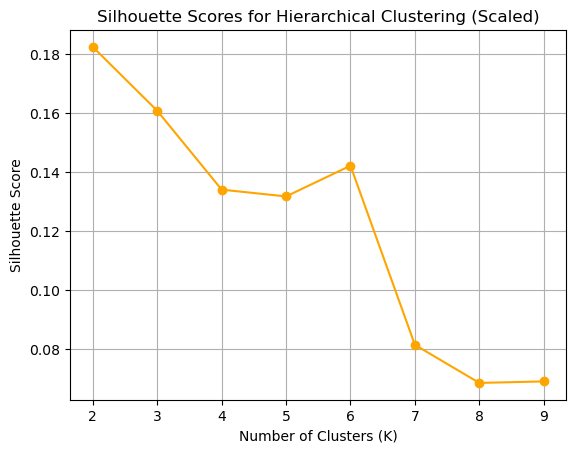

In [88]:
# sil plot for Hierarchical Clustering
# PCA input
plt.plot(range(2, 10), sil_scores_hier_pca, marker='o')
plt.title("Silhouette Scores for Hierarchical Clustering (PCA)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Scaled input
plt.plot(range(2, 10), sil_scores_hier_scaled, marker='o', color='orange')
plt.title("Silhouette Scores for Hierarchical Clustering (Scaled)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


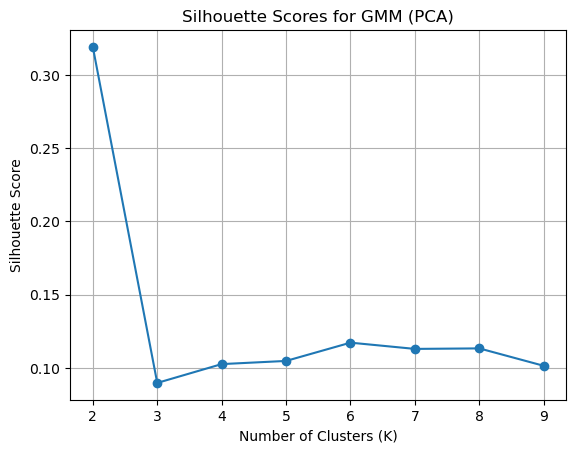

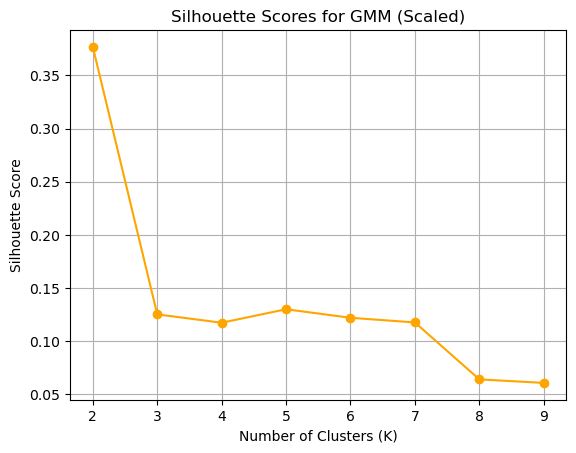

In [92]:
# sil plot for GMM
# PCA input
plt.plot(range(2, 10), sil_scores_gmm , marker='o')
plt.title("Silhouette Scores for GMM (PCA)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Scaled input
plt.plot(range(2, 10), sil_scores_gmm_scaled, marker='o', color='orange')
plt.title("Silhouette Scores for GMM (Scaled)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


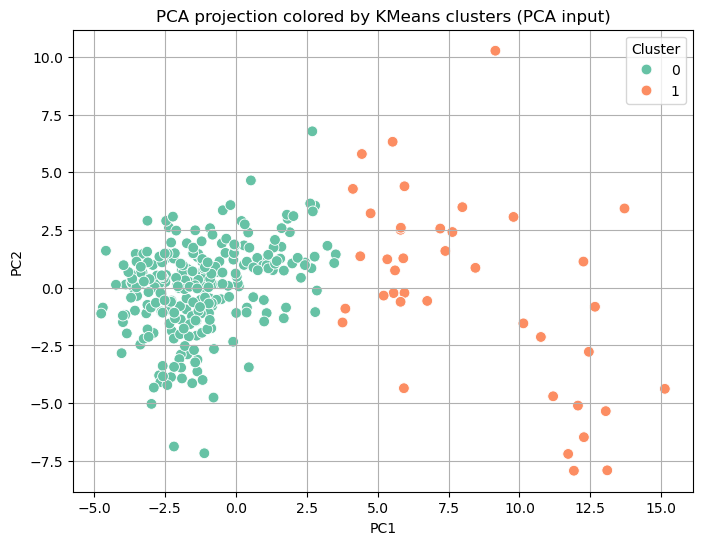

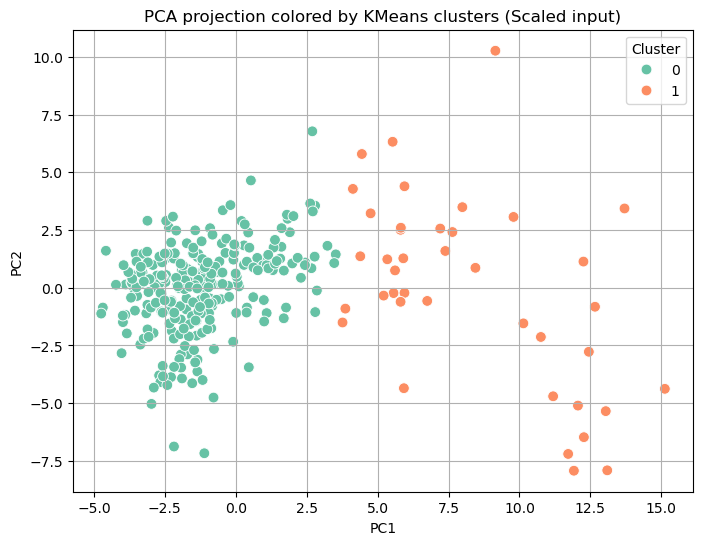

In [95]:
# PCA Scatterplot with Cluster Labels
# to be repeated with different clustering methods
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=case2_data['kmeans_sil_cluster_pca'],
    palette='Set2',
    s=60
)
plt.title("PCA projection colored by KMeans clusters (PCA input)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=case2_data['kmeans_sil_cluster_scaled'],
    palette='Set2',
    s=60
)
plt.title("PCA projection colored by KMeans clusters (Scaled input)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

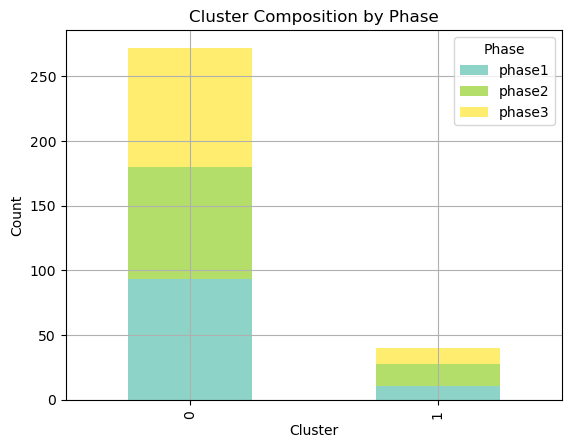

In [96]:
# Cluster Composition by Phase
# to be repaeted with different clustering methods
pd.crosstab(case2_data['kmeans_sil_cluster_pca'], case2_data['Phase']).plot(kind='bar', stacked=True, colormap='Set3')
plt.title("Cluster Composition by Phase")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Phase")
plt.grid(True)
plt.show()


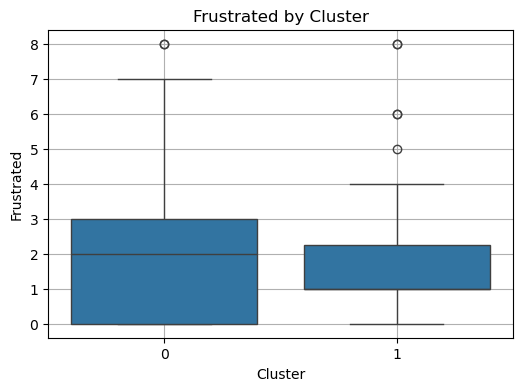

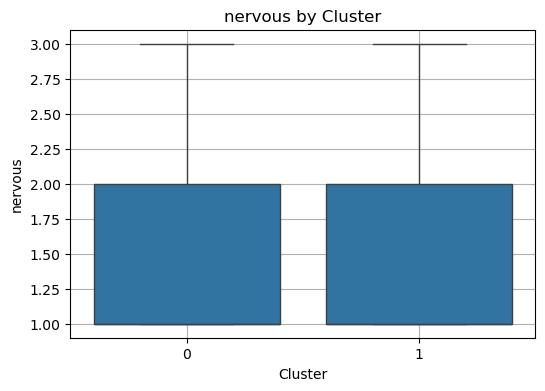

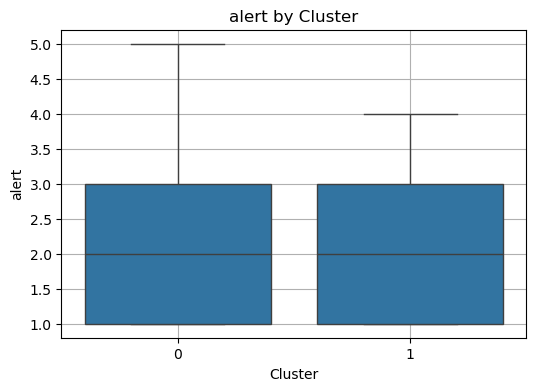

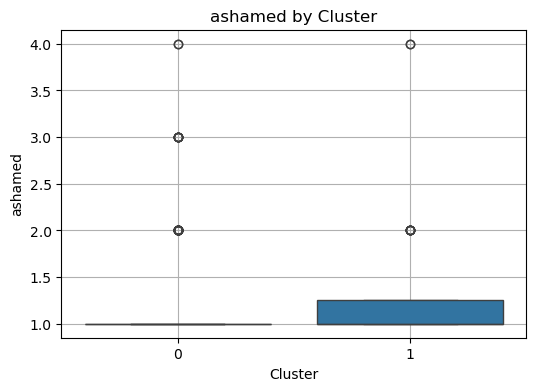

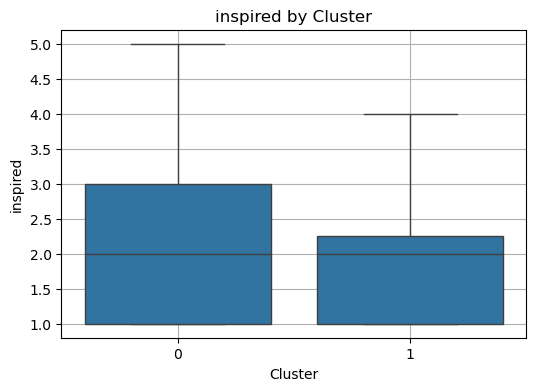

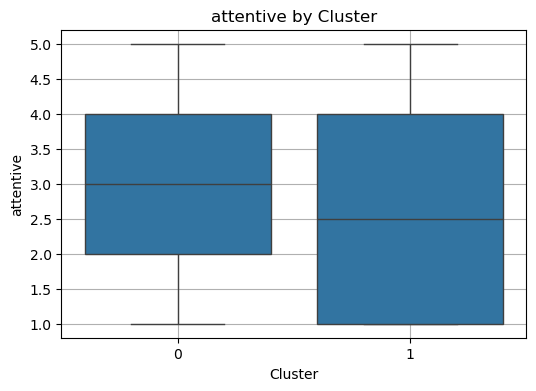

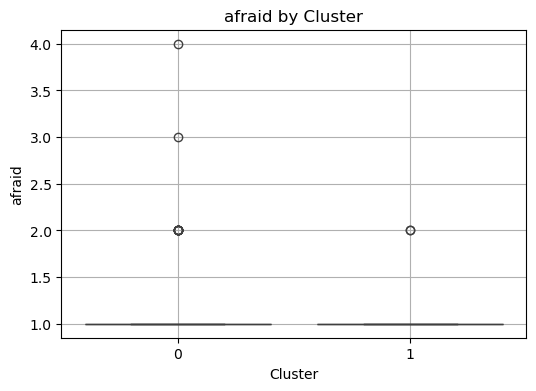

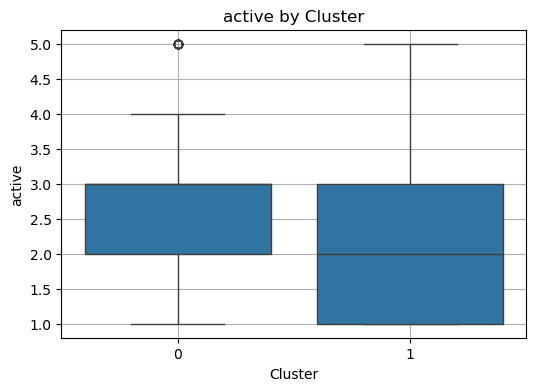

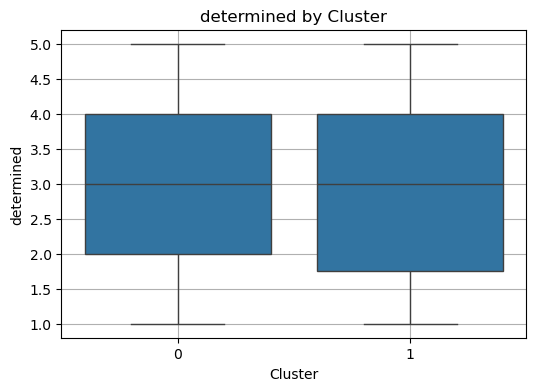

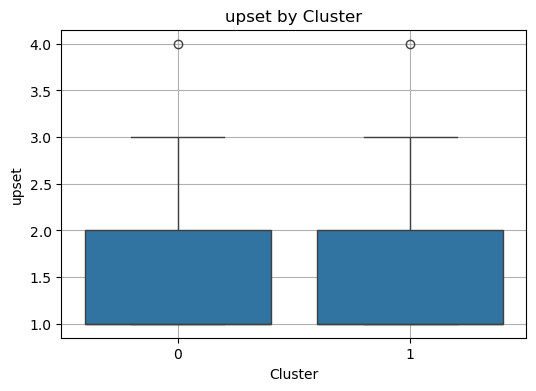

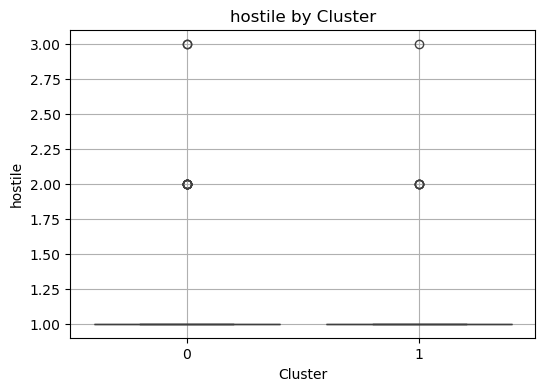

In [97]:
emotion_cols = ['Frustrated', 'nervous', 'alert', 'ashamed', 'inspired', 
                'attentive', 'afraid', 'active', 'determined', 'upset', 'hostile']

for emotion in emotion_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=case2_data['kmeans_sil_cluster_pca'], y=case2_data[emotion])
    plt.title(f"{emotion} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(emotion)
    plt.grid(True)
    plt.show()


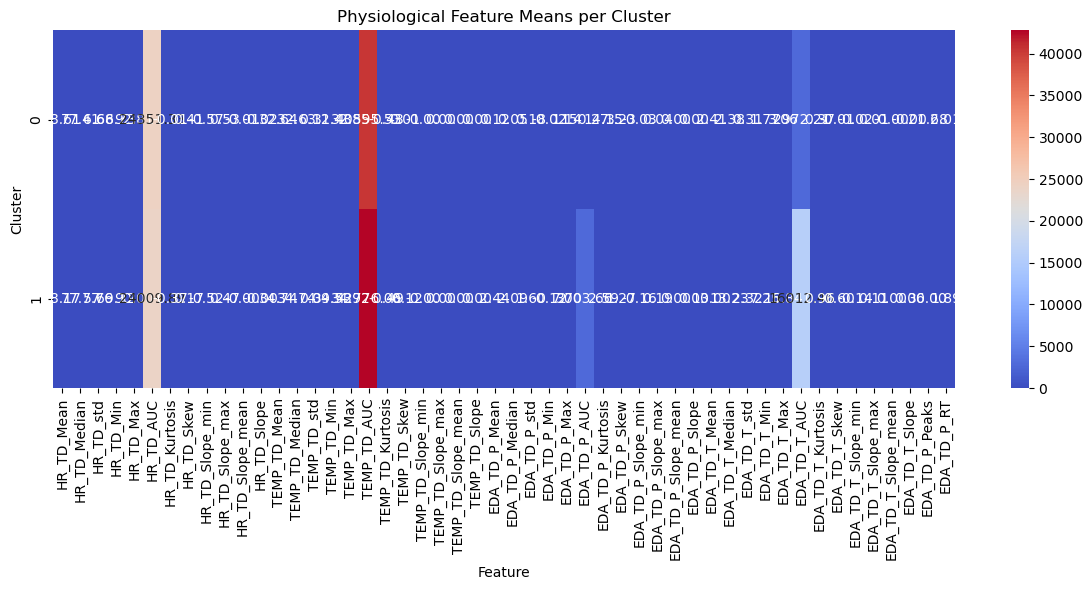

In [98]:
# Compute mean of physiological features only
cluster_means = case2_data.groupby('kmeans_sil_cluster_pca').mean(numeric_only=True)

# Select physiological feature columns if needed (first 50?)
physio_cols = case2_data.columns[1:51]

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means[physio_cols], cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Physiological Feature Means per Cluster")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


4. Reporting
- Describe each cluster
- Which features drive separation?
- Do clusters correspond to stress vs. rest states?
- Are there patterns across sessions, roles, or individuals?